# Objective 
We will implement a fully functioning under complete autoencoder for 
feature learning using MNIST data set


### Necessary Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.utils.data
from torch.autograd import Variable
from torchsummary import summary
from torchvision.utils import save_image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
transform = transforms.ToTensor()

## Data Preprocessing 

### Load the training set

In [ ]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
train_data

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../Data/MNIST/raw/train-images-idx3-ubyte.gz to ../Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../Data/MNIST/raw/train-labels-idx1-ubyte.gz to ../Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../Data/MNIST/raw




Extracting ../Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../Data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

### Load the test set
There's a companion set of MNIST data containing 10,000 records accessible by setting train=False. As before, torchvision will only download this once, and in the future will look for the local copy.

In [ ]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
model_data=train_data+test_data
total_count=len(model_data)
total_count

70000

### Split 70:30

In [ ]:
train_count = int(0.7 * total_count) 
test_count = int(0.3 * total_count)

In [ ]:
train_data, test_data = torch.utils.data.random_split(model_data, (train_count, test_count))
print(len(train_data))
print(len(test_data))
type(train_data)

49000
21000


torch.utils.data.dataset.Subset

In [ ]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

Calling the first record from <tt>train_data</tt> returns a two-item tuple. The first item is our 28x28 tensor representing the image. The second is a label, in this case the number "5".

In [ ]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 1


### View the image
Matplotlib can interpret pixel values through a variety of <a href='https://matplotlib.org/tutorials/colors/colormaps.html'>colormaps</a>.

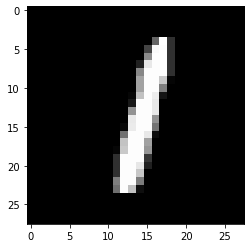

In [ ]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray");

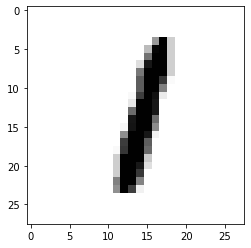

In [ ]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gist_yarg");

In [ ]:
torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

### View a batch of images


Labels:  [   7    4    1    9    4    6    8    6    4    9    1    0]


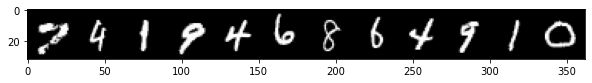

In [ ]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Defining the Auto encoder 

In [ ]:
class SAE(nn.Module):
    def __init__(self, in_sz=784, out_sz=56, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])  #self.fc3 = nn.Linear(layers[1],layers[2])
        self.fc3 = nn.Linear(layers[1],out_sz)
        
        self.fc4 = nn.Linear(out_sz,layers[1])     #self.fc6 = nn.Linear(layers[2],layers[1])
        self.fc5 = nn.Linear(layers[1],layers[0])
        self.fc6 = nn.Linear(layers[0],in_sz)
        

    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        self.output=X
        X = F.relu(self.fc4(X))
        X = F.relu(self.fc5(X))
        X = self.fc6(X)
        self.reconstruct=X
        
        
        return F.log_softmax(X, dim=1)

    def get_output(self):
        return self.output
    def get_reconstruct(self):
        return self.reconstruct

In [ ]:
torch.manual_seed(101)
model = SAE()
model

SAE(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=56, bias=True)
  (fc4): Linear(in_features=56, out_features=84, bias=True)
  (fc5): Linear(in_features=84, out_features=120, bias=True)
  (fc6): Linear(in_features=120, out_features=784, bias=True)
)

## Count the model parameters
This optional step shows that the number of trainable parameters in our model matches the equation above.

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

## Supporting functions

In [ ]:
def plot_loss(train_losses,test_losses):
  plt.plot(train_losses, label='training loss')
  plt.plot(test_losses, label='test reconstruction loss')
  plt.title('Loss at the end of each epoch')
  plt.legend();

In [ ]:
def plot_accuracy(train_correct,test_correct):
  plt.plot([t/49000 for t in train_correct], label='training accuracy')
  plt.plot([t/21000 for t in test_correct], label='test reconstruction accuracy')
  plt.title('Accuracy at the end of each epoch')
  plt.legend();

### Train the model


In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [ ]:

def train_loss_accuracy(train_loader,model):

  import time
  start_time = time.time()

  epochs = 10
  train_losses = []
  test_losses = []
  train_correct = []
  test_correct = []
  
  

  for i in range(epochs):
      trn_corr = 0
      tst_corr = 0
      
      # Run the training batches
      for b, (X_train, y_train) in enumerate(train_loader):
          b+=1
          # Apply the model
          y_pred= model(X_train.view(100, -1))  # Here we flatten X_train
          loss = criterion(y_pred, y_train)
  
          # Tally the number of correct predictions
          predicted = torch.max(y_pred.data, 1)[1]
          batch_corr = (predicted == y_train).sum()
          trn_corr += batch_corr
          
          # Update parameters
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # Print interim results
          if b%200 == 0:
              print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/49000]  loss: {loss.item():10.8f}  \
  accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
      
      # Update train loss & accuracy for the epoch
      train_losses.append(loss)
      train_correct.append(trn_corr)
      # Run the testing batches
      with torch.no_grad():
          for b, (X_test, y_test) in enumerate(test_loader):

              # Apply the model
              y_val = model(X_test.view(500, -1))  # Here we flatten X_test

              # Tally the number of correct predictions
              predicted = torch.max(y_val.data, 1)[1] 
              tst_corr += (predicted == y_test).sum()
      
      # Update test loss & accuracy for the epoch
      loss = criterion(y_val, y_test)
      test_losses.append(loss)
      test_correct.append(tst_corr)
          
  print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  


  return train_losses,train_correct,test_losses,test_correct    #,final_outputs    

In [ ]:
def save_train_dataset(train_loader,model,hidden_neurons):
  train_outputs = np.empty((0,hidden_neurons), float)
  target_train= np.empty((0,1), int)
  # Run the training batches
  for b, (X_train, y_train) in enumerate(train_loader):
      #print(y_train)

      b+=1
      # Apply the model
      y_pred= model(X_train.view(100, -1))  # Here we flatten X_train
      target_train = np.append(target_train,y_train.numpy().reshape(-1,1),axis=0)
      
      outputs=model.get_output()
      outputs = outputs.cpu().data
      train_outputs = np.append( train_outputs, outputs.numpy(), axis=0)  
    
  np.save('train.npy', train_outputs)
  np.save('train-labels.npy', target_train)

In [ ]:
def save_test_dataset(test_loader,model,hidden_neurons):
  test_outputs =  np.empty((0,hidden_neurons),float)
  test_target= np.empty((0,1), int)
  
  # Run the training batches
  for b, (X_test, y_test) in enumerate(test_loader):
      b+=1
      # Apply the model
      y_pred= model(X_test.view(500, -1))  # Here we flatten X_train
      test_target = np.append(test_target,y_test.numpy().reshape(-1,1),axis=0)
      
      outputs=model.get_output()
      outputs = outputs.cpu().data
      test_outputs = np.append( test_outputs, outputs.numpy(), axis=0)  
     
  np.save('test.npy', test_outputs)
  np.save('test-labels.npy', test_target)

In [ ]:
# Run the testing batches
def test_loss_accuracy(test_data,model):
  
  test_load_all = DataLoader(test_data, batch_size=21000, shuffle=False)
  test_losses=[]
  with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
       
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        loss = criterion(y_val, y_test)

        test_losses.append(loss)
  print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')
  return  (correct.item()*100/(len(test_data)),test_losses)

## Define loss function & optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=model0.01)

### Flatten the training data
The batch tensors fed in by DataLoader have a shape of [100, 1, 28, 28]:

In [ ]:
# Load the first batch, print its shape
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break
    
# EQUIVALENT TO:
# dataiter = iter(train_loader)
# images, labels = dataiter.next()
# print('Batch shape:', images.size())

Batch shape: torch.Size([100, 1, 28, 28])


## Basic Implementation

We can flatten them using <tt>.view()</tt>

In [ ]:

images.view(100,-1).size()

torch.Size([100, 784])

In [ ]:
train_losses,train_correct,test_losses,test_correct = train_loss_accuracy(train_loader,model)

epoch:  0  batch:  200 [ 20000/49000]  loss: 0.17689985    accuracy:  65.660%
epoch:  0  batch:  400 [ 40000/49000]  loss: 0.14311151    accuracy:  78.935%
epoch:  1  batch:  200 [ 20000/49000]  loss: 0.07012110    accuracy:  94.535%
epoch:  1  batch:  400 [ 40000/49000]  loss: 0.16639262    accuracy:  94.782%
epoch:  2  batch:  200 [ 20000/49000]  loss: 0.14477083    accuracy:  96.020%
epoch:  2  batch:  400 [ 40000/49000]  loss: 0.04095319    accuracy:  95.905%
epoch:  3  batch:  200 [ 20000/49000]  loss: 0.37693605    accuracy:  96.240%
epoch:  3  batch:  400 [ 40000/49000]  loss: 0.21902426    accuracy:  96.280%
epoch:  4  batch:  200 [ 20000/49000]  loss: 0.06181435    accuracy:  96.740%
epoch:  4  batch:  400 [ 40000/49000]  loss: 0.02644430    accuracy:  96.645%
epoch:  5  batch:  200 [ 20000/49000]  loss: 0.06310299    accuracy:  97.130%
epoch:  5  batch:  400 [ 40000/49000]  loss: 0.05204427    accuracy:  97.108%
epoch:  6  batch:  200 [ 20000/49000]  loss: 0.23725463    accur

In [ ]:
save_train_dataset(train_loader,model,56)

In [ ]:
save_test_dataset(test_loader,model,56)

In [ ]:
train=np.load('train.npy')
print(len(train))

train_labels=np.load('train-labels.npy')
print(len(train_labels))

print(train[0])
print(train_labels[0:10])


49000
49000
[ 0.          0.          0.          0.          0.          0.
  0.          3.79492307  0.          0.         56.29275894  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         13.21927643  0.          0.          0.          0.
  0.          0.          6.70122671  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
[[7.]
 [1.]
 [4.]
 [1.]
 [9.]
 [5.]
 [0.]
 [0.]
 [6.]
 [1.]]


In [ ]:
test=np.load('test.npy')
print(len(test))

test_labels=np.load('test-labels.npy')
print(len(test_labels))

print(test[0])
print(test_labels[0:10])

21000
21000
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          4.15441895  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         14.05968475  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          7.96925116 37.116436   77.45285034  0.          0.
  0.          0.         37.77600479  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         52.39165115
  2.68930316  0.        ]
[[   3]
 [   0]
 [   4]
 [   2]
 [   4]
 [   8]
 [   0]
 [   2]
 [   4]
 [   7]]


In [ ]:
losses=[i.item() for i in train_losses]
print('Average training loss: {}'.format(np.mean(np.array(losses))))

Average training loss: 0.14897979535162448


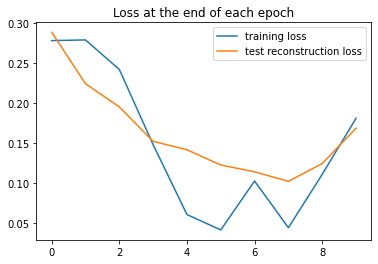

In [ ]:
plot_loss(train_losses,test_losses)

In [ ]:
test_correct

[tensor(19548),
 tensor(19883),
 tensor(19905),
 tensor(20209),
 tensor(20181),
 tensor(20234),
 tensor(20195),
 tensor(20267),
 tensor(20327),
 tensor(20274)]

In [ ]:
train_correct

[tensor(39290),
 tensor(46377),
 tensor(46872),
 tensor(47243),
 tensor(47379),
 tensor(47557),
 tensor(47676),
 tensor(47717),
 tensor(47765),
 tensor(47698)]

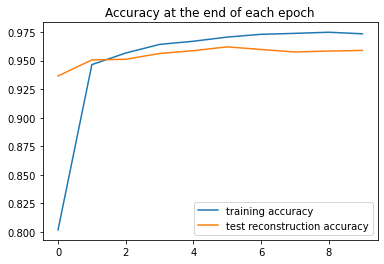

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
(test_accuracy,test_loss)=test_loss_accuracy(test_data,model)

Test accuracy: 20378/21000 =  97.038%


In [ ]:
losses=[i.item() for i in test_loss]
print('Test loss: {}'.format(np.mean(np.array(losses))))

Test loss: 0.17567941546440125


In [ ]:
torch.save(model.state_dict(), 'CIFAR10-BestAutoencoder-Model.pt')

In [ ]:
summary(model,(120,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 120, 120]          94,200
            Linear-2              [-1, 120, 84]          10,164
            Linear-3              [-1, 120, 20]           1,700
            Linear-4              [-1, 120, 84]           1,764
            Linear-5             [-1, 120, 120]          10,200
            Linear-6             [-1, 120, 784]          94,864
Total params: 212,892
Trainable params: 212,892
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.36
Forward/backward pass size (MB): 1.11
Params size (MB): 0.81
Estimated Total Size (MB): 2.28
----------------------------------------------------------------


## Variations

In [ ]:
hidden_neuron_lst=[20,40,50,60]

In [ ]:
def Plot_test_recons_loss(x,y):
  plt.plot(x, y)
    
  # naming the x axis
  plt.xlabel('number of bottleneck hidden neurons ')
  # naming the y axis
  plt.ylabel('loss')
    
  # giving a title to my graph
  plt.title('Test_reconstructions loss  VS Hidden neurons!')
    
  # function to show the plot
  plt.show()

### Adam optimiser

In [ ]:
test_Recon_losses=[]
for i in hidden_neuron_lst:
  torch.manual_seed(101)
  modelAdam = SAE(out_sz=i)
  print(count_parameters(modelAdam))
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(modelAdam.parameters(), lr=0.01)
  train_losses,train_correct,test_losses,test_correct = train_loss_accuracy(train_loader,modelAdam)
  (test_accuracy,test_loss)=test_loss_accuracy(test_data,modelAdam)
  losses=[i.item() for i in test_loss]
  test_Recon_losses.append(np.mean(np.array(losses)))

 94080
   120
 10080
    84
  1680
    20
  1680
    84
 10080
   120
 94080
   784
______
212892
None
epoch:  0  batch:  200 [ 20000/49000]  loss: 0.37366095    accuracy:  64.210%
epoch:  0  batch:  400 [ 40000/49000]  loss: 0.35386753    accuracy:  78.020%
epoch:  1  batch:  200 [ 20000/49000]  loss: 0.22784302    accuracy:  94.445%
epoch:  1  batch:  400 [ 40000/49000]  loss: 0.08862063    accuracy:  94.638%
epoch:  2  batch:  200 [ 20000/49000]  loss: 0.03031295    accuracy:  95.960%
epoch:  2  batch:  400 [ 40000/49000]  loss: 0.17653485    accuracy:  96.005%
epoch:  3  batch:  200 [ 20000/49000]  loss: 0.31502625    accuracy:  96.435%
epoch:  3  batch:  400 [ 40000/49000]  loss: 0.08746783    accuracy:  96.597%
epoch:  4  batch:  200 [ 20000/49000]  loss: 0.11932169    accuracy:  97.110%
epoch:  4  batch:  400 [ 40000/49000]  loss: 0.12577893    accuracy:  96.910%
epoch:  5  batch:  200 [ 20000/49000]  loss: 0.16077934    accuracy:  96.955%
epoch:  5  batch:  400 [ 40000/49000]  

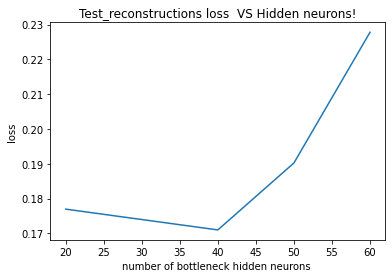

In [ ]:
Plot_test_recons_loss(hidden_neuron_lst,test_Recon_losses)

### RMSProp

In [ ]:
test_Recon_losses=[]
for i in hidden_neuron_lst:
  torch.manual_seed(101)
  modelrms = SAE(out_sz=i)
  print(count_parameters(modelrms))
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.RMSprop(modelrms.parameters(), lr=0.01)
  train_losses,train_correct,test_losses,test_correct = train_loss_accuracy(train_loader,modelrms)
  (test_accuracy,test_loss)=test_loss_accuracy(test_data,modelrms)
  losses=[i.item() for i in test_loss]
  test_Recon_losses.append(np.mean(np.array(losses)))

 94080
   120
 10080
    84
  1680
    20
  1680
    84
 10080
   120
 94080
   784
______
212892
None
epoch:  0  batch:  200 [ 20000/49000]  loss: 2.31122398    accuracy:  10.075%
epoch:  0  batch:  400 [ 40000/49000]  loss: 2.31729960    accuracy:  10.405%
epoch:  1  batch:  200 [ 20000/49000]  loss: 2.30299401    accuracy:  10.850%
epoch:  1  batch:  400 [ 40000/49000]  loss: 2.30422497    accuracy:  10.748%
epoch:  2  batch:  200 [ 20000/49000]  loss: 2.29952478    accuracy:  11.050%
epoch:  2  batch:  400 [ 40000/49000]  loss: 2.30241489    accuracy:  10.790%
epoch:  3  batch:  200 [ 20000/49000]  loss: 2.30331945    accuracy:  11.090%
epoch:  3  batch:  400 [ 40000/49000]  loss: 2.30927896    accuracy:  11.072%
epoch:  4  batch:  200 [ 20000/49000]  loss: 2.29978848    accuracy:  11.160%
epoch:  4  batch:  400 [ 40000/49000]  loss: 2.29046774    accuracy:  10.855%
epoch:  5  batch:  200 [ 20000/49000]  loss: 2.29743791    accuracy:  11.210%
epoch:  5  batch:  400 [ 40000/49000]  

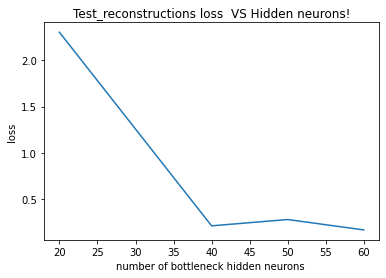

In [ ]:
Plot_test_recons_loss(hidden_neuron_lst,test_Recon_losses)

### SGD with momentum

In [ ]:
test_Recon_losses=[]
for i in hidden_neuron_lst:
  torch.manual_seed(101)
  modelSGD = SAE(out_sz=i)
  print(count_parameters(modelSGD))
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(modelSGD.parameters(), lr=0.01,momentum=0.9)
  train_losses,train_correct,test_losses,test_correct = train_loss_accuracy(train_loader,modelSGD)
  (test_accuracy,test_loss)=test_loss_accuracy(test_data,modelSGD)
  losses=[i.item() for i in test_loss]
  test_Recon_losses.append(np.mean(np.array(losses)))

 94080
   120
 10080
    84
  1680
    20
  1680
    84
 10080
   120
 94080
   784
______
212892
None
epoch:  0  batch:  200 [ 20000/49000]  loss: 2.21910548    accuracy:  11.360%
epoch:  0  batch:  400 [ 40000/49000]  loss: 1.32351840    accuracy:  23.035%
epoch:  1  batch:  200 [ 20000/49000]  loss: 0.47019139    accuracy:  78.750%
epoch:  1  batch:  400 [ 40000/49000]  loss: 0.22931373    accuracy:  84.050%
epoch:  2  batch:  200 [ 20000/49000]  loss: 0.08771989    accuracy:  93.010%
epoch:  2  batch:  400 [ 40000/49000]  loss: 0.19215082    accuracy:  93.720%
epoch:  3  batch:  200 [ 20000/49000]  loss: 0.16496211    accuracy:  96.230%
epoch:  3  batch:  400 [ 40000/49000]  loss: 0.17926483    accuracy:  96.225%
epoch:  4  batch:  200 [ 20000/49000]  loss: 0.02555310    accuracy:  97.130%
epoch:  4  batch:  400 [ 40000/49000]  loss: 0.06843333    accuracy:  97.215%
epoch:  5  batch:  200 [ 20000/49000]  loss: 0.07770804    accuracy:  97.875%
epoch:  5  batch:  400 [ 40000/49000]  

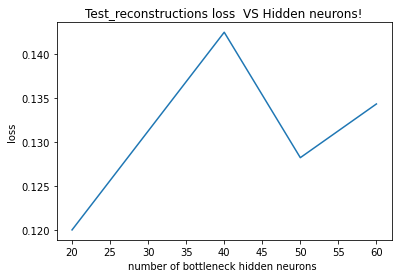

In [ ]:
Plot_test_recons_loss(hidden_neuron_lst,test_Recon_losses)

### SGD without momentum

In [ ]:
test_Recon_losses=[]
for i in hidden_neuron_lst:
  torch.manual_seed(101)
  modelSGD_ = SAE(out_sz=i)
  print(count_parameters(modelSGD_))
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(modelSGD_.parameters(), lr=0.01,momentum=0)
  train_losses,train_correct,test_losses,test_correct = train_loss_accuracy(train_loader,modelSGD_)
  (test_accuracy,test_loss)=test_loss_accuracy(test_data,modelSGD_)
  losses=[i.item() for i in test_loss]
  test_Recon_losses.append(np.mean(np.array(losses)))

 94080
   120
 10080
    84
  1680
    20
  1680
    84
 10080
   120
 94080
   784
______
212892
None
epoch:  0  batch:  200 [ 20000/49000]  loss: 6.29625130    accuracy:   6.980%
epoch:  0  batch:  400 [ 40000/49000]  loss: 3.73529267    accuracy:   8.765%
epoch:  1  batch:  200 [ 20000/49000]  loss: 2.29302430    accuracy:  10.405%
epoch:  1  batch:  400 [ 40000/49000]  loss: 2.29108286    accuracy:  10.807%
epoch:  2  batch:  200 [ 20000/49000]  loss: 2.22340679    accuracy:  16.035%
epoch:  2  batch:  400 [ 40000/49000]  loss: 2.18903375    accuracy:  17.858%
epoch:  3  batch:  200 [ 20000/49000]  loss: 1.95645189    accuracy:  26.045%
epoch:  3  batch:  400 [ 40000/49000]  loss: 1.84566879    accuracy:  28.527%
epoch:  4  batch:  200 [ 20000/49000]  loss: 1.56694400    accuracy:  37.240%
epoch:  4  batch:  400 [ 40000/49000]  loss: 1.49984026    accuracy:  38.672%
epoch:  5  batch:  200 [ 20000/49000]  loss: 1.45192277    accuracy:  44.465%
epoch:  5  batch:  400 [ 40000/49000]  

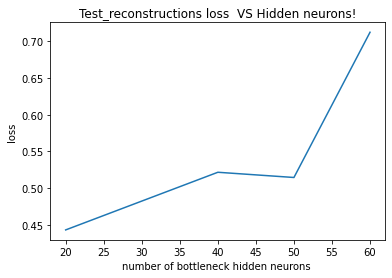

In [ ]:
Plot_test_recons_loss(hidden_neuron_lst,test_Recon_losses)

## Best Model
   Best model is obtianed using Adam at hidden neurons=40

In [ ]:
torch.manual_seed(101)
modelAdam = SAE(out_sz=40)
print(count_parameters(modelAdam))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelAdam.parameters(), lr=0.01)
train_losses,train_correct,test_losses,test_correct = train_loss_accuracy(train_loader,modelAdam)
#(test_accuracy,test_loss)=test_loss_accuracy(test_data,modelAdam)
#losses=[i.item() for i in test_loss]
#test_Recon_losses.append(np.mean(np.array(losses)))

 94080
   120
 10080
    84
  3360
    40
  3360
    84
 10080
   120
 94080
   784
______
216272
None
epoch:  0  batch:  200 [ 20000/49000]  loss: 0.35225362    accuracy:  60.420%
epoch:  0  batch:  400 [ 40000/49000]  loss: 0.25161517    accuracy:  76.030%
epoch:  1  batch:  200 [ 20000/49000]  loss: 0.26678234    accuracy:  94.600%
epoch:  1  batch:  400 [ 40000/49000]  loss: 0.11704984    accuracy:  94.692%
epoch:  2  batch:  200 [ 20000/49000]  loss: 0.06050238    accuracy:  95.815%
epoch:  2  batch:  400 [ 40000/49000]  loss: 0.26113871    accuracy:  95.757%
epoch:  3  batch:  200 [ 20000/49000]  loss: 0.03884675    accuracy:  96.070%
epoch:  3  batch:  400 [ 40000/49000]  loss: 0.20373708    accuracy:  96.302%
epoch:  4  batch:  200 [ 20000/49000]  loss: 0.08479146    accuracy:  96.590%
epoch:  4  batch:  400 [ 40000/49000]  loss: 0.07600765    accuracy:  96.515%
epoch:  5  batch:  200 [ 20000/49000]  loss: 0.26502919    accuracy:  97.005%
epoch:  5  batch:  400 [ 40000/49000]  

In [ ]:
losses=[i.item() for i in train_losses]
print('Average training loss: {}'.format(np.mean(np.array(losses))))

Average training loss: 0.1166729487478733


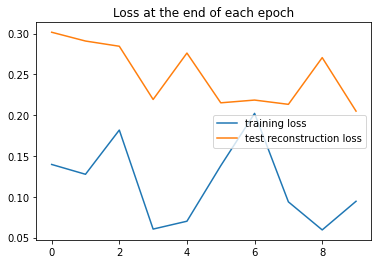

In [ ]:
plot_loss(train_losses,test_losses)

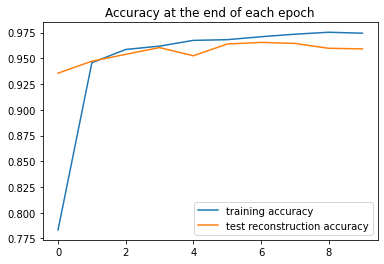

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
(test_accuracy,test_loss)=test_loss_accuracy(test_data,model)

Test accuracy: 20180/21000 =  96.095%


In [ ]:
losses=[i.item() for i in test_loss]
print('Test loss: {}'.format(np.mean(np.array(losses))))

Test loss: 0.17765840888023376


In [ ]:
save_train_dataset(train_loader,modelAdam,40)

In [ ]:
save_test_dataset(test_loader,modelAdam,40)

In [ ]:
torch.save(model.state_dict(), 'CIFAR10-BestSAE-Model.pt')

In [ ]:
summary(model,(120,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 120, 120]          94,200
            Linear-2              [-1, 120, 84]          10,164
            Linear-3              [-1, 120, 56]           4,760
            Linear-4              [-1, 120, 84]           4,788
            Linear-5             [-1, 120, 120]          10,200
            Linear-6             [-1, 120, 784]          94,864
Total params: 218,976
Trainable params: 218,976
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.36
Forward/backward pass size (MB): 1.14
Params size (MB): 0.84
Estimated Total Size (MB): 2.34
----------------------------------------------------------------


In [ ]:
test_outputs =  np.empty((0,784),float)
test_target= np.empty((0,1), int)

# Run the training batches
for b, (X_test, y_test) in enumerate(test_loader):
    b+=1
    # Apply the model
    y_pred= modelAdam(X_test.view(500, -1))  # Here we flatten X_train
    test_target = np.append(test_target,y_test.numpy().reshape(-1,1),axis=0)
    
    outputs=modelAdam.get_reconstruct()
    outputs = outputs.cpu().data
    test_outputs = np.append( test_outputs, outputs.numpy(), axis=0)

In [ ]:
test_outputs.shape

(21000, 784)

In [ ]:
test_outputs=test_outputs/len(test_outputs)

## Pca Reconstruction for the best model

#### Preparing the data set for PCA
     https://stackoverflow.com/questions/54897646/pytorch-datasets-converting-entire-dataset-to-numpy/54904668

### Alternate way of getting data

In [ ]:

loader_train = DataLoader(train_data, batch_size=len(train_data))
loader_test = DataLoader(test_data, batch_size=len(test_data))

X_train = next(iter(loader_train))[0].numpy()
y_train=next(iter(loader_train))[1].numpy()

X_test = next(iter(loader_test))[0].numpy()
y_test = next(iter(loader_test))[1].numpy()


In [ ]:
X_train.shape

(49000, 1, 28, 28)

In [ ]:
X_train=X_train.reshape(49000,784)
X_train.shape

(49000, 784)

In [ ]:
X_test=X_test.reshape(21000,784)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
y_test

(49000, 784)
(21000, 784)
(49000,)
(21000,)


array([   3,    3,    8, ...,    0,    6,    7])

### Defining n_components in PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
lower_dimensional_data = pca.fit_transform(X_test)

In [ ]:
pca.n_components_

40

#### Pca Inverse transform

In [ ]:
#lower_dimensional_data=test

In [ ]:
approximation = pca.inverse_transform(lower_dimensional_data)
approximation+=X_test.mean()

In [ ]:
approximation.shape

(21000, 784)

In [ ]:

a = approximation
test = torch.from_numpy(a)


In [ ]:
test=test.type(torch.FloatTensor)
y_test=torch.from_numpy(y_test)
y_test

tensor([5, 9, 2,  ..., 0, 4, 3])

In [ ]:
test.view(len(test), -1).size()

torch.Size([21000, 784])

In [ ]:

test_losses=[]
with torch.no_grad():
  correct = 0
  y_val = model(test)# pass in a flattened view of X_test
  
  predicted = torch.max(y_val,1)[1]
  correct += (predicted == y_test).sum()
  print(y_val)
  print(y_test)
  loss = criterion(y_val, y_test)
  test_losses.append(loss)
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')


tensor([[-1.8346e+01, -2.6128e+01, -2.6789e+01,  ..., -1.6968e+02,
         -1.5481e+02, -1.6464e+02],
        [-1.2929e+01, -1.5565e+01, -1.7636e+01,  ..., -4.3507e+01,
         -5.1477e+01, -4.7921e+01],
        [-6.3811e+01, -4.7083e+01, -4.7684e-07,  ..., -1.6453e+02,
         -2.1363e+02, -1.9265e+02],
        ...,
        [-6.2232e-04, -1.3817e+01, -1.0349e+01,  ..., -1.8678e+02,
         -1.7537e+02, -1.8125e+02],
        [-1.8115e+01, -1.6204e+01, -1.1606e+01,  ..., -9.0412e+01,
         -9.2020e+01, -8.8515e+01],
        [-2.7930e+01, -1.8948e+01, -1.1795e+01,  ..., -7.3240e+01,
         -7.7773e+01, -7.3804e+01]])
tensor([5, 9, 2,  ..., 0, 4, 3])
Test accuracy: 19942/21000 =  94.962%


In [ ]:
loss = 0
for i in range(len(X_test)):
  loss+=((X_test[i] - approximation[i]) ** 2).mean()
loss/len(X_test)

0.03156550066075509

#### Calculating the Auto encoder loss

In [ ]:
test_outputs
loss = 0
for i in range(len(X_test)):
  loss+=((X_test[i] - test_outputs[i]) ** 2).mean()
loss/len(X_test)

0.11300697556314498

### Observation:
  As we can see from the above two impplementations that loss of best optimiser autoencoder Adam is 0.1776 on test data is comparitvely less than the loss in pca reconstruction loss which is 0.218

#### Additional useful code

In [ ]:
train=np.load('train.npy')
print(len(train))

train_labels=np.load('train-labels.npy')
print(len(train_labels))

print(train[0])



49000
49000
[ 0.          0.          0.          0.          0.          0.
  0.          0.         13.00463295  0.         40.74394226  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          6.00007248  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          8.37154865  0.          0.
 21.28633308  0.          0.          0.        ]


In [ ]:
test=np.load('test.npy')
print(len(test))

test_labels=np.load('test-labels.npy')
print(len(test_labels))

print(test[0])


21000
21000
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 23.8663826  15.17771339  0.          0.          0.          0.
  0.          0.         22.32218361  0.          0.          0.
  0.          0.          0.          0.         18.48301506  0.
  0.          0.          0.          0.        ]


In [ ]:
y_test=test_labels.reshape(1,21000)
y_test=y_test[0]
y_test